In [2]:
!pip install pylatex

  Using cached PyLaTeX-1.4.2-py3-none-any.whl
  Using cached ordered_set-4.1.0-py3-none-any.whl.metadata (5.3 kB)
Using cached ordered_set-4.1.0-py3-none-any.whl (7.6 kB)


In [38]:
import os
import uuid
import shutil
import pylatex
import pandas as pd
import lightkurve as lk 
import matplotlib.pyplot as plt

from datetime import datetime
from tqdm.notebook import tqdm
from multiprocessing import cpu_count, Pool
from pylatex.section import Chapter, Subsection
from pylatex import Document, Section, Figure, NoEscape, Command

plt.ioff()
%run pipeline.ipynb

OUTPUT_PATH = "/home/jovyan/SRMP-JMAG/output"
AFTER_56_ONLY = False

In [31]:
def get_sectors(tic):
    """Returns a list of available sectors given an TIC."""
    sectors = []
    for result in lk.search_tesscut(str(tic)):
        sectors.append(int(result.mission[0].split(" ")[2]))
        
    return {"tic": tic, "sectors": sectors}

def get_targets(tics):
    """Constructs a dictionary of TICs and available sectors from a list of TICs"""
    targets = []

    with tqdm(total=len(tics)) as pbar:
        for tic in tics:
            targets.append(get_sectors(tic))
            pbar.update()
    return targets
                
targets = get_targets(["TIC 404144841", "TIC 363963079", "TIC 206544316"])

  0%|          | 0/3 [00:00<?, ?it/s]

In [18]:
import json
with open("./output/targets.json", "w+") as f:
    f.write(json.dumps(targets))

In [35]:
complex = {}
not_complex = {}

for target in tqdm(targets):
    for sector in tqdm(target["sectors"], leave=False, desc=target["tic"]):
        if sector <= 56 and AFTER_56_ONLY:
            continue
        lc = load_lc(f"{target['tic']}", sector)
        
        # Determine complexity
        if complexitycheck(lc):
            if target["tic"] not in complex.keys():
                complex[target["tic"]] = []
            complex[target["tic"]].append(sector)
        else:
            if target["tic"] not in not_complex.keys():
                not_complex[target["tic"]] = []
            not_complex[target["tic"]].append(sector)
        if not os.path.isdir(f"{OUTPUT_PATH}/{target['tic']}"):
            os.mkdir(f"{OUTPUT_PATH}/{target['tic']}")

        try:
            # Plot river and save
            plt.figure(river_plot(lc).number) # this is necessary to make the output current and save the correct figure.
            plt.savefig(f"{OUTPUT_PATH}/{target['tic']}/{sector}_river.png")
            plt.close()
    
            # Plot lc and save
            plt.figure(graph_lc(lc).number) 
            plt.savefig(f"{OUTPUT_PATH}/{target['tic']}/{sector}_plot.png")
            plt.close()
    
            # Make periodogram and save
            plt.figure(lombscargle(lc).number) 
            plt.savefig(f"{OUTPUT_PATH}/{target['tic']}/{sector}_periodogram.png")
            plt.close()
        except:
            print(f"Failed to generate one or more plots for {tic}:{sector}")

  0%|          | 0/3 [00:00<?, ?it/s]

TIC 404144841:   0%|          | 0/4 [00:00<?, ?it/s]

Inflating...
Removing 103 bad data points (out of 1248) using the TESS provided QUALITY array
Summing over 1 x 1 pixel lightcurves. Weighting=None


/opt/conda/envs/tess/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Inflating...
Removing 16 bad data points (out of 3477) using the TESS provided QUALITY array
Summing over 1 x 1 pixel lightcurves. Weighting=None
Inflating...
Removing 12 bad data points (out of 3705) using the TESS provided QUALITY array
Summing over 1 x 1 pixel lightcurves. Weighting=None
Inflating...
Removing 155 bad data points (out of 11356) using the TESS provided QUALITY array
Summing over 1 x 1 pixel lightcurves. Weighting=None


TIC 363963079:   0%|          | 0/7 [00:00<?, ?it/s]

Inflating...
Removing 17 bad data points (out of 968) using the TESS provided QUALITY array
Summing over 1 x 1 pixel lightcurves. Weighting=None
Inflating...
Removing 7 bad data points (out of 1093) using the TESS provided QUALITY array
Summing over 1 x 1 pixel lightcurves. Weighting=None
Inflating...
Removing 10 bad data points (out of 3495) using the TESS provided QUALITY array
Summing over 1 x 1 pixel lightcurves. Weighting=None
Inflating...
Removing 15 bad data points (out of 3489) using the TESS provided QUALITY array
Summing over 1 x 1 pixel lightcurves. Weighting=None
Inflating...
Removing 538 bad data points (out of 3353) using the TESS provided QUALITY array
Summing over 1 x 1 pixel lightcurves. Weighting=None


/opt/conda/envs/tess/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Inflating...
Removing 59 bad data points (out of 10713) using the TESS provided QUALITY array
Summing over 1 x 1 pixel lightcurves. Weighting=None
Inflating...
Removing 26 bad data points (out of 10837) using the TESS provided QUALITY array
Summing over 1 x 1 pixel lightcurves. Weighting=None


/opt/conda/envs/tess/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/conda/envs/tess/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


TIC 206544316:   0%|          | 0/6 [00:00<?, ?it/s]

Inflating...
Removing 15 bad data points (out of 1282) using the TESS provided QUALITY array
Summing over 1 x 1 pixel lightcurves. Weighting=None
Inflating...
Removing 49 bad data points (out of 1245) using the TESS provided QUALITY array
Summing over 1 x 1 pixel lightcurves. Weighting=None
Inflating...
Removing 15 bad data points (out of 3464) using the TESS provided QUALITY array
Summing over 1 x 1 pixel lightcurves. Weighting=None
Inflating...
Removing 63 bad data points (out of 3635) using the TESS provided QUALITY array
Summing over 1 x 1 pixel lightcurves. Weighting=None
Inflating...
Removing 421 bad data points (out of 11639) using the TESS provided QUALITY array
Summing over 1 x 1 pixel lightcurves. Weighting=None
Inflating...
Removing 1425 bad data points (out of 10856) using the TESS provided QUALITY array
Summing over 1 x 1 pixel lightcurves. Weighting=None


In [36]:
def make_dataframes(l):
    
    df = pd.DataFrame()
    
    tics = []
    sectors = []
    for tic in list(l.keys()):
        for sector in l[tic]:
            tics.append(tic)
            sectors.append(sector)
    
    df["TIC"] = tics
    df["Sectors"] = sectors

    return df

make_dataframes(complex).to_csv(f"{OUTPUT_PATH}/complex.csv")
make_dataframes(not_complex).to_csv(f"{OUTPUT_PATH}/not_complex.csv")

In [40]:
def make_chapter(title, data, doc):
    with doc.create(Chapter(title)):
        for tic in data.keys():
            doc.append(NoEscape(r'\newpage'))
            with doc.create(Section(f"{tic}")):
                for i, sector in enumerate(data[tic]):
                    if i > 0:
                        doc.append(NoEscape(r'\newpage'))
                    with doc.create(Subsection(f"Sector {sector}", label=f"{tic}_{sector}")):
                        lc = load_lc(f"{tic}", sector)

                        failed = []
                        for plot_type in ["plot", "river", "periodogram"]:
                            if not os.path.exists(f"{OUTPUT_PATH}/{tic}/{sector}_{plot_type}.png"):
                                failed.append(plot_type)
                                continue
                            with doc.create(Figure(position="H")) as plot:
                                doc.append(NoEscape(r'\begin{center}'))
                                plot.add_image(f"{OUTPUT_PATH}/{tic}/{sector}_{plot_type}.png", width=NoEscape(r'0.5\textwidth'))
                                doc.append(NoEscape(r'\end{center}'))

                        if failed != []:
                            doc.append("Failed to generate " + ", ".join(failed) + f" for {tic}.")

def make_pdf_report():
    try:
        shutil.rmtree("./build")
    except:
        pass
    os.mkdir("./build")

    doc = Document(documentclass="report", lmodern=False, geometry_options={"margin": "0.5in", "top": "0.5in", "bottom": "0.5in"})

    doc.preamble.append(Command("title", "JMAG Complex Rotator Pipeline Results"))
    doc.preamble.append(Command("date", f"Generated on {datetime.now().strftime('%x %X')}"))
    doc.preamble.append(NoEscape(r'\usepackage{float}'))
    doc.preamble.append(NoEscape(r'\usepackage{hyperref}'))
    doc.preamble.append(NoEscape(r'\hypersetup{colorlinks=true}'))


    doc.append(NoEscape(r'\maketitle'))
    doc.append(NoEscape(r'\tableofcontents'))
    
    make_chapter("Complex Rotators", complex, doc)
    make_chapter("Non-Complex Rotators", not_complex, doc)
    doc.generate_tex("./build/main")
    
    os.system("cd build && pdflatex -interaction=nonstopmode main.tex && pdflatex -interaction=nonstopmode main.tex")
    
make_pdf_report()

This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(./main.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/report.cls
Document Class: report 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/base/fontenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/lastpage/lastpage.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/graphics/graphicx.sty
(/usr/share/texlive/texmf-dis

In [13]:
lc = load_lc("TIC 224283342", 29)

In [14]:
lc.to_periodogram().period_at_max_power

<Quantity 0.89048408 d>

<Axes: title={'center': 'TIC 224283342'}, xlabel='Phase', ylabel='Cycle'>

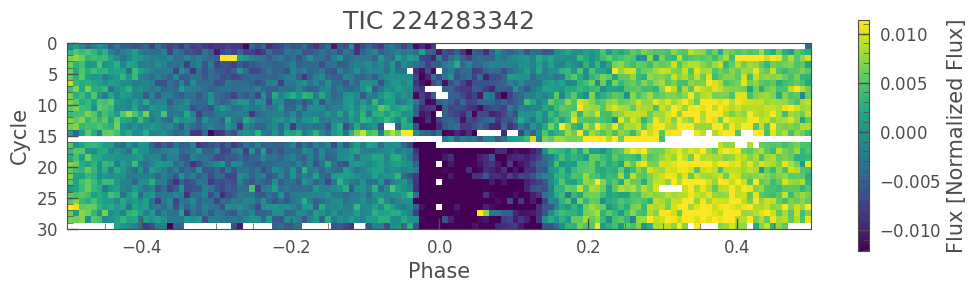

In [23]:
lc.fold(period=0.887).plot_river()

<Axes: xlabel='Phase [JD]', ylabel='Flux'>

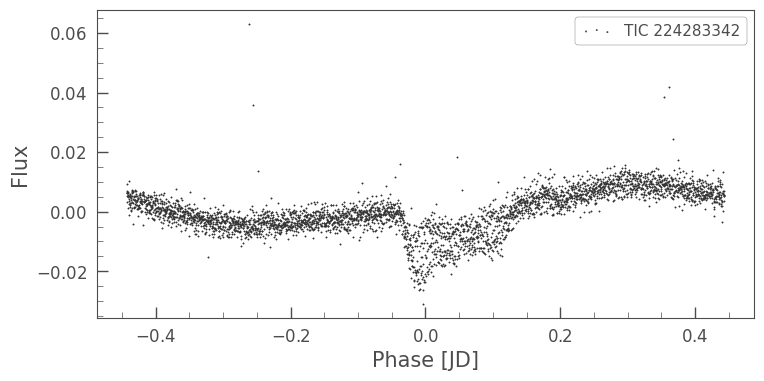

In [29]:
period = 0.887
lc.fold(period=period, epoch_time=0.7).scatter()